# RL
### Index
- [Experiment 1: Slippery vs Non slippery](#experiment-1-slippery-vs-non-slippery)
- [Experiment 2: Q-learning vs Boltzmann](#experiment-2-q-learning-vs-boltzmann)
- [Experiment 3: How Q-values propagate (craving) and show optimal policies with arrows](#experiment-3-how-q-values-propagate-craving-and-show-optimal-policies-with-arrows)
- [Experiment 4: Comparison of different reward_hole values](#experiment-4-comparison-of-different-reward_hole-values)
- [Experiment 5: Experience replay](#experiment-5-experience-replay)
- [Experiment 6: Providing frozen lake layout](#experiment-6--providing-frozen-lake-layout)

# Imports

In [42]:
# Imports experiment 1
import random
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Experiment 1: Slippery vs Non slippery

## custom wrapper for reward shaping

In [223]:
# Set random seed for reproducibility
seed = np.random.seed(42)

# Configuration - now with both slippery conditions
class Config:
    def __init__(self, slippery=True):
        self.alpha = 0.8
        self.gamma = 0.95
        self.epsilon = 1.0
        self.min_epsilon = 0.05
        self.epsilon_decay = 0.9999
        self.episodes = 30000
        self.eval_episodes = 1000
        self.slippery = slippery  # Now configurable
        self.reward_goal = 20
        self.reward_hole = -1
        self.reward_step = -0.01

# Core algorithm

In [224]:
def train_q_learning(config, env, random_state):
    """Train Q-learning with ε-greedy exploration, now tracking Q-values"""
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    avg_max_q_values = []  # To track average max Q-values
    
    for episode in range(config.episodes):
        state, _ = env.reset(seed=int(random_state.randint(0, 10000)))
        done = False
        total_reward = 0
        
        while not done:
            if random_state.random() < config.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Reward shaping
            if terminated and reward == 0:
                reward = config.reward_hole
            elif reward == 1:
                reward = config.reward_goal
            else:
                reward = config.reward_step
            
            # Q-learning update
            q_table[state, action] += config.alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )
            
            state = next_state
            total_reward += reward
        
        # Track average max Q-value
        avg_max_q = np.mean(np.max(q_table, axis=1))
        avg_max_q_values.append(avg_max_q)
        
        # Decay epsilon
        config.epsilon = max(config.min_epsilon, config.epsilon * config.epsilon_decay)
        episode_rewards.append(total_reward)
    
    return q_table, episode_rewards, avg_max_q_values  # Now returning Q-values too

# Training Function

In [225]:
def run_slippery_comparison():
    """Compare slippery vs non-slippery performance, now tracking Q-values"""
    random_state = np.random.RandomState(42)
    
    results = {
        'slippery': {'rewards': None, 'success_rate': None, 'avg_max_q': None},
        'non_slippery': {'rewards': None, 'success_rate': None, 'avg_max_q': None}
    }
    
    for condition in [True, False]:
        config = Config(slippery=condition)
        condition_name = 'slippery' if condition else 'non_slippery'
        
        env = gym.make(
            "FrozenLake-v1",
            desc=["SFFF", "FHFH", "FFFH", "HFFG"],
            is_slippery=condition
        )
        
        q_table, rewards, avg_max_q = train_q_learning(config, env, random_state)
        success_rate = evaluate(q_table, config, random_state)
        
        results[condition_name]['rewards'] = rewards
        results[condition_name]['success_rate'] = success_rate
        results[condition_name]['avg_max_q'] = avg_max_q
    
    return results

# Create Plots

In [226]:
def plot_reward_comparison(results):
    """Plot comparison of rewards between conditions"""
    plt.figure(figsize=(12, 6))
    
    for condition in ['slippery', 'non_slippery']:
        rewards = results[condition]['rewards']
        ma_rewards = np.convolve(rewards, np.ones(1000)/1000, mode='valid')
        
        plt.plot(ma_rewards, 
                label=f"{condition.title()} (SR: {results[condition]['success_rate']:.1%})",
                linewidth=2)
    
    plt.title("Reward Comparison (1000-episode MA)", fontsize=14)
    plt.xlabel("Training Episodes", fontsize=12)
    plt.ylabel("Average Reward", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xlim(0, 29000)
    plt.show()

def plot_q_value_comparison(results):
    """Plot comparison of average max Q-values during training"""
    plt.figure(figsize=(12, 6))
    
    for condition in ['slippery', 'non_slippery']:
        q_values = results[condition]['avg_max_q']
        ma_q_values = np.convolve(q_values, np.ones(1000)/1000, mode='valid')
        
        plt.plot(ma_q_values, 
                label=f"{condition.title()}",
                linewidth=2)
    
    plt.title("Average Max Q-Value Comparison (1000-episode MA)", fontsize=14)
    plt.xlabel("Training Episodes", fontsize=12)
    plt.ylabel("Average Max Q-Value", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xlim(0, 29000)
    plt.show()

# Main execution

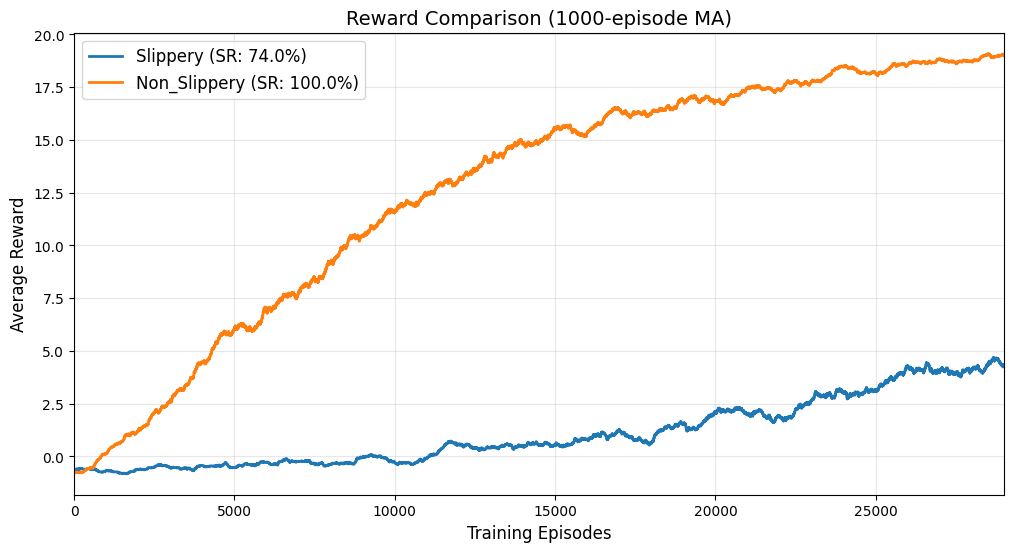

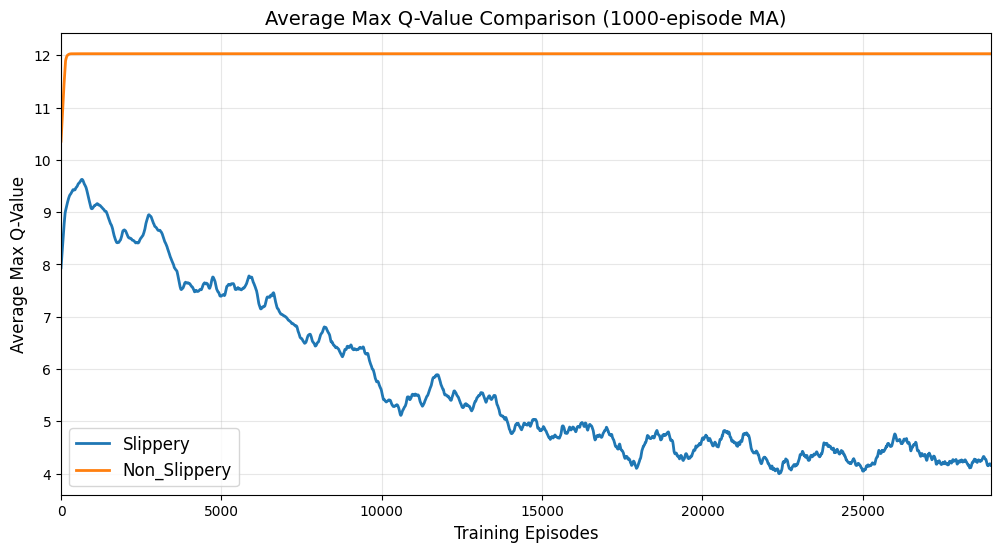


Final Success Rates:
Slippery: 74.0%
Non-slippery: 100.0%


In [227]:
# Run the comparison
results = run_slippery_comparison()

# Generate plots
plot_reward_comparison(results)
plot_q_value_comparison(results)

# Print final statistics
print("\nFinal Success Rates:")
print(f"Slippery: {results['slippery']['success_rate']:.1%}")
print(f"Non-slippery: {results['non_slippery']['success_rate']:.1%}")

# Experiment 2: Q-learning vs Boltzmann

### Enviroment and Config

In [7]:
# Configuration
class Config:
    def __init__(self):
        self.alpha = 0.8
        self.gamma = 0.95
        self.epsilon = 1.0
        self.min_epsilon = 0.05
        self.epsilon_decay = 0.9999
        self.episodes = 30000
        self.eval_episodes = 1000
        self.slippery = True
        self.reward_goal = 20
        self.reward_hole = -1
        self.reward_step = -0.01

def create_env(slippery=True, seed=42):
    env = gym.make(
        "FrozenLake-v1",
        desc=["SFFF", "FHFH", "FFFH", "HFFG"],
        is_slippery=slippery
    )
    env.reset(seed=seed)
    return env

### Core Algorithms

In [8]:
def boltzmann_exploration(q_values, temp=1.0):
    if temp <= 0:
        return np.argmax(q_values)
    scaled_q = (q_values - np.max(q_values)) / max(temp, 1e-10)
    exp_q = np.exp(scaled_q)
    probabilities = exp_q / np.sum(exp_q)
    if np.isnan(probabilities).any():
        probabilities = np.ones_like(q_values) / len(q_values)
    return np.random.choice(len(q_values), p=probabilities)

def train_epsilon_greedy(config, env):
    np.random.seed(42)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    successes = []
    max_qs = []

    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.random() < config.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated and reward == 0:
                reward = config.reward_hole
            elif reward == 1:
                reward = config.reward_goal
            else:
                reward = config.reward_step

            q_table[state, action] += config.alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward

        config.epsilon = max(config.min_epsilon, config.epsilon * config.epsilon_decay)
        episode_rewards.append(total_reward)
        successes.append(1 if reward == config.reward_goal else 0)
        max_qs.append(np.max(q_table))

    return q_table, {
        "rewards": episode_rewards,
        "max_qs": max_qs,
        "successes": successes
    }

def train_boltzmann(config, env, initial_temp=1.0, temp_decay=0.9995, min_temp=0.1):
    np.random.seed(42)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    successes = []
    max_qs = []
    temperature = initial_temp

    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = boltzmann_exploration(q_table[state], temperature)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reward = config.reward_goal if reward == 1 else config.reward_hole
            else:
                row, col = divmod(state, 4)
                goal_dist = abs(row - 3) + abs(col - 3)
                reward = config.reward_step + 0.01 * (6 - goal_dist)

            current_alpha = config.alpha * (1 - episode / config.episodes)
            q_table[state, action] += current_alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward

        temperature = max(min_temp, temperature * temp_decay)
        episode_rewards.append(total_reward)
        successes.append(1 if reward == config.reward_goal else 0)
        max_qs.append(np.max(q_table))

    return q_table, {
        "rewards": episode_rewards,
        "max_qs": max_qs,
        "successes": successes
    }

### Evaluation

In [9]:
def evaluate(q_table, config):
    eval_env = create_env(config.slippery, seed=1042)
    successes = 0
    for _ in range(config.eval_episodes):
        state, _ = eval_env.reset()
        done = False
        while not done:
            action = np.argmax(q_table[state])
            state, _, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            if terminated and state == 15:
                successes += 1
    return successes / config.eval_episodes

### Create Plots

In [17]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")

def plot_training_metrics(metrics_eps, metrics_boltz, window=100):
    episodes = np.arange(len(metrics_eps["rewards"]))
    smoothed_range = np.arange(window - 1, len(episodes))

    # --- 1. Reward per Episode ---
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, metrics_eps["rewards"], alpha=0.2, label="ε-greedy (raw)")
    plt.plot(episodes, metrics_boltz["rewards"], alpha=0.2, label="Boltzmann (raw)")
    plt.plot(smoothed_range, moving_average(metrics_eps["rewards"], window), label="ε-greedy (avg)")
    plt.plot(smoothed_range, moving_average(metrics_boltz["rewards"], window), label="Boltzmann (avg)")
    plt.title("Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 2. Max Q-value per Episode ---
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, metrics_eps["max_qs"], alpha=0.2, label="ε-greedy (raw)")
    plt.plot(episodes, metrics_boltz["max_qs"], alpha=0.2, label="Boltzmann (raw)")
    plt.plot(smoothed_range, moving_average(metrics_eps["max_qs"], window), label="ε-greedy (avg)")
    plt.plot(smoothed_range, moving_average(metrics_boltz["max_qs"], window), label="Boltzmann (avg)")
    plt.title("Max Q-values")
    plt.xlabel("Episode")
    plt.ylabel("Max Q-value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 3. Success Rate Over Time ---
    success_eps = np.cumsum(metrics_eps["successes"]) / (episodes + 1)
    success_boltz = np.cumsum(metrics_boltz["successes"]) / (episodes + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(episodes, success_eps, label="ε-greedy", linewidth=2)
    plt.plot(episodes, success_boltz, label="Boltzmann", linewidth=2)
    plt.title("Success Rate Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Success Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Experiment Runner


Evaluation Success Rates:
ε-Greedy:  28.2%
Boltzmann: 59.9%


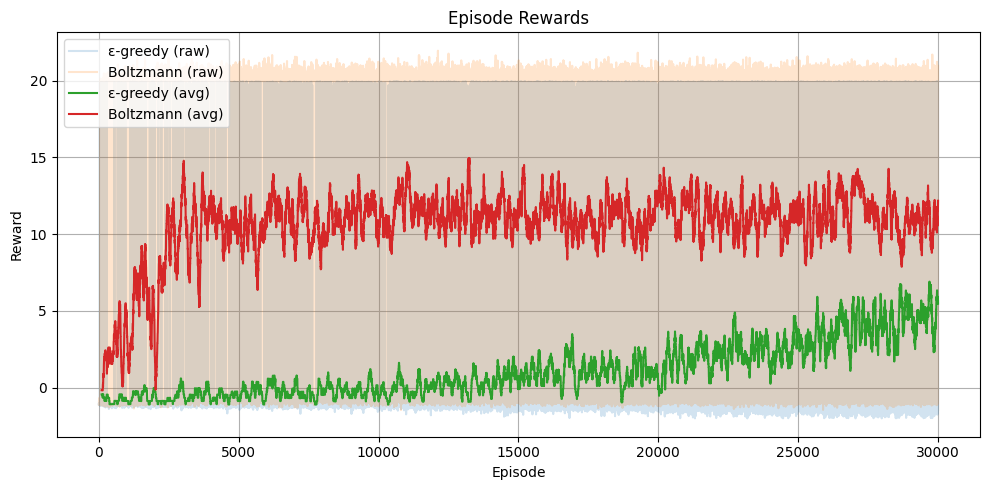

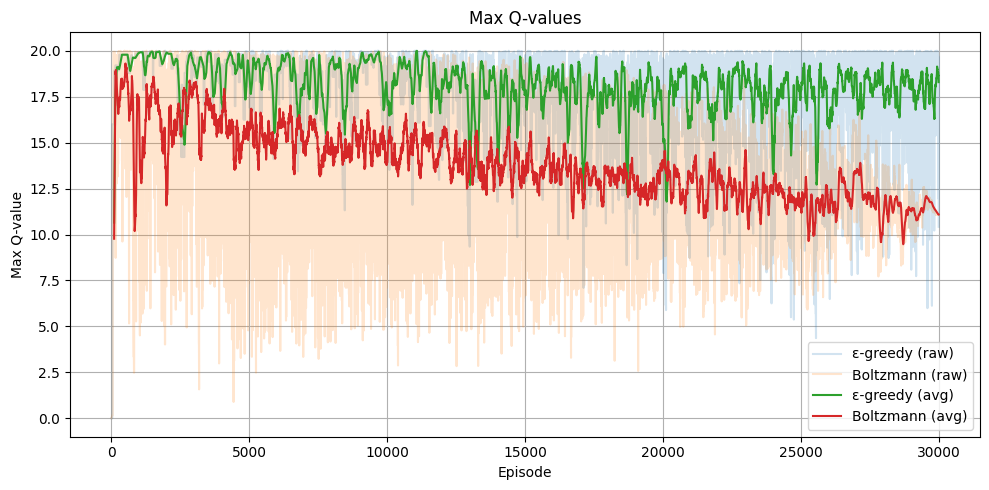

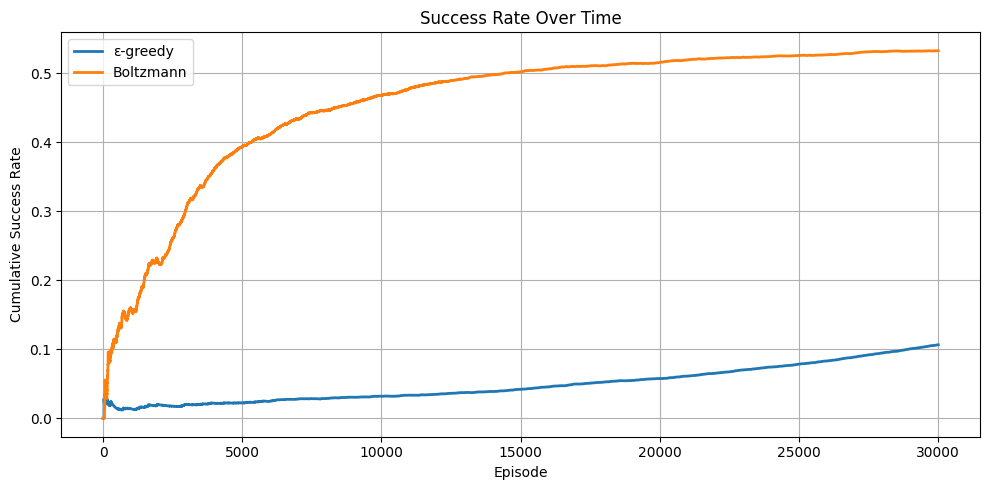

In [19]:
config = Config()
env = create_env(config.slippery, seed=42)

q_eps, metrics_eps = train_epsilon_greedy(config, env)
eps_success = evaluate(q_eps, config)

env = create_env(config.slippery, seed=42)
q_boltz, metrics_boltz = train_boltzmann(config, env)
boltz_success = evaluate(q_boltz, config)

print(f"\nEvaluation Success Rates:")
print(f"ε-Greedy:  {eps_success:.1%}")
print(f"Boltzmann: {boltz_success:.1%}")

plot_training_metrics(metrics_eps, metrics_boltz)

# Experiment 3: How Q-values propagate (craving) and show optimal policies with arrows

### Initial Setup

In [25]:
# Configuration
class Config:
    def __init__(self):
        self.alpha = 0.8
        self.gamma = 0.95
        self.epsilon = 1.0
        self.min_epsilon = 0.05
        self.epsilon_decay = 0.9999
        self.episodes = 30000
        self.eval_episodes = 1000
        self.slippery = True
        self.reward_goal = 20
        self.reward_hole = -1
        self.reward_step = -0.01

def create_env(slippery=True, seed=42):
    env = gym.make(
        "FrozenLake-v1",
        desc=["SFFF", "FHFH", "FFFH", "HFFG"],
        is_slippery=slippery
    )
    env.reset(seed=seed)
    return env

### Q-Learning Algorithm

In [26]:
def boltzmann_exploration(q_values, temp=1.0):
    if temp <= 0:
        return np.argmax(q_values)
    scaled_q = (q_values - np.max(q_values)) / max(temp, 1e-10)
    exp_q = np.exp(scaled_q)
    probabilities = exp_q / np.sum(exp_q)
    if np.isnan(probabilities).any():
        probabilities = np.ones_like(q_values) / len(q_values)
    return np.random.choice(len(q_values), p=probabilities)

def train_boltzmann(config, env, initial_temp=1.0, temp_decay=0.9995, min_temp=0.1):
    np.random.seed(42)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    successes = []
    max_qs = []
    temperature = initial_temp

    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = boltzmann_exploration(q_table[state], temperature)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reward = config.reward_goal if reward == 1 else config.reward_hole
            else:
                row, col = divmod(state, 4)
                goal_dist = abs(row - 3) + abs(col - 3)
                reward = config.reward_step + 0.01 * (6 - goal_dist)

            current_alpha = config.alpha * (1 - episode / config.episodes)
            q_table[state, action] += current_alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward

        temperature = max(min_temp, temperature * temp_decay)
        episode_rewards.append(total_reward)
        successes.append(1 if reward == config.reward_goal else 0)
        max_qs.append(np.max(q_table))

    return q_table, {
        "rewards": episode_rewards,
        "max_qs": max_qs,
        "successes": successes
    }

### Evaluate Policy

In [27]:
def evaluate(q_table, config):
    eval_env = create_env(config.slippery, seed=1042)
    successes = 0
    for _ in range(config.eval_episodes):
        state, _ = eval_env.reset()
        done = False
        while not done:
            action = np.argmax(q_table[state])
            state, _, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            if terminated and state == 15:
                successes += 1
    return successes / config.eval_episodes

### Visualize Optimal Policy with Q-values

Success rate after training: 59.90%


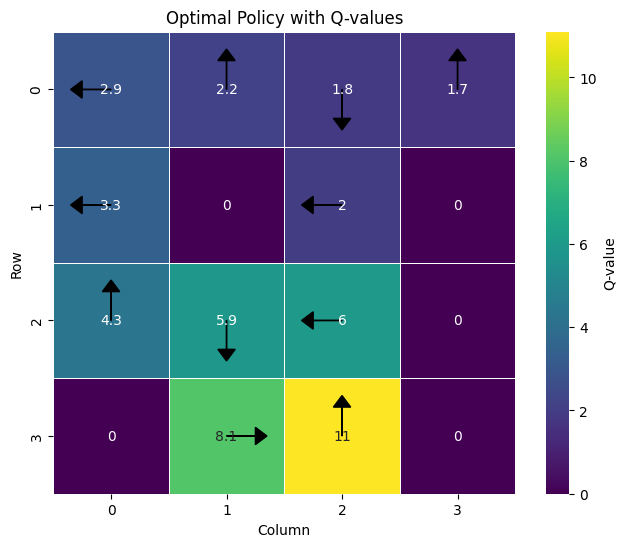

In [31]:
def plot_q_values_with_policy(q_table, env, figsize=(8, 6)):
    grid_size = int(np.sqrt(env.observation_space.n))
    max_q_values = np.max(q_table, axis=1).reshape((grid_size, grid_size))

    plt.figure(figsize=figsize)
    sns.heatmap(max_q_values, annot=True, cmap='viridis', cbar_kws={'label': 'Q-value'}, linewidths=0.5, square=True)

    holes = [5, 7, 11, 12]
    goal = 15

    for row in range(grid_size):
        for col in range(grid_size):
            state = row * grid_size + col

            if state in holes or state == goal:
                continue  # Skip holes and goal

            action = np.argmax(q_table[state])
            dx, dy = 0, 0
            if action == 0:   # Left
                dx = -0.25
            elif action == 1: # Down
                dy = 0.25
            elif action == 2: # Right
                dx = 0.25
            elif action == 3: # Up
                dy = -0.25

            plt.arrow(col + 0.5, row + 0.5, dx, dy,
                      head_width=0.15, head_length=0.1, fc='k', ec='k')

    plt.title("Optimal Policy with Q-values")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()

# Run training and plot
config = Config()
env = create_env(config.slippery, seed=42)
q_table, stats = train_boltzmann(config, env)
print(f"Success rate after training: {evaluate(q_table, config) * 100:.2f}%")
plot_q_values_with_policy(q_table, env)

# Experiment 4: Comparison of different reward_hole values

### Initial Config

In [ ]:
# Configuration
class Config:
    def __init__(self):
        self.alpha = 0.8
        self.gamma = 0.95
        self.epsilon = 1.0
        self.min_epsilon = 0.05
        self.epsilon_decay = 0.9999
        self.episodes = 30000
        self.eval_episodes = 1000
        self.slippery = True
        self.reward_goal = 20
        self.reward_hole = -1
        self.reward_step = -0.01

def create_env(slippery=True, seed=42):
    env = gym.make(
        "FrozenLake-v1",
        desc=["SFFF", "FHFH", "FFFH", "HFFG"],
        is_slippery=slippery
    )
    env.reset(seed=seed)
    return env

### Q-Learning Algorithm

In [ ]:
def boltzmann_exploration(q_values, temp=1.0):
    if temp <= 0:
        return np.argmax(q_values)
    scaled_q = (q_values - np.max(q_values)) / max(temp, 1e-10)
    exp_q = np.exp(scaled_q)
    probabilities = exp_q / np.sum(exp_q)
    if np.isnan(probabilities).any():
        probabilities = np.ones_like(q_values) / len(q_values)
    return np.random.choice(len(q_values), p=probabilities)

def train_boltzmann(config, env, initial_temp=1.0, temp_decay=0.9995, min_temp=0.1):
    np.random.seed(42)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    successes = []
    max_qs = []
    temperature = initial_temp

    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = boltzmann_exploration(q_table[state], temperature)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reward = config.reward_goal if reward == 1 else config.reward_hole
            else:
                row, col = divmod(state, 4)
                goal_dist = abs(row - 3) + abs(col - 3)
                reward = config.reward_step + 0.01 * (6 - goal_dist)

            current_alpha = config.alpha * (1 - episode / config.episodes)
            q_table[state, action] += current_alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward

        temperature = max(min_temp, temperature * temp_decay)
        episode_rewards.append(total_reward)
        successes.append(1 if reward == config.reward_goal else 0)
        max_qs.append(np.max(q_table))

    return q_table, {
        "rewards": episode_rewards,
        "max_qs": max_qs,
        "successes": successes
    }

### Evaluation function

In [ ]:
def evaluate(q_table, config):
    eval_env = create_env(config.slippery, seed=1042)
    successes = 0
    for _ in range(config.eval_episodes):
        state, _ = eval_env.reset()
        done = False
        while not done:
            action = np.argmax(q_table[state])
            state, _, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            if terminated and state == 15:
                successes += 1
    return successes / config.eval_episodes

# Run training for different reward_hole values
reward_hole_values = [-1, -5, -10]
success_rates = []
episode_rewards = []
max_q_values = []
successes = []

for reward_hole in reward_hole_values:
    config = Config(reward_hole=reward_hole)
    env = create_env(config.slippery, seed=42)
    q_table, stats = train_boltzmann(config, env)
    success_rate = evaluate(q_table, config)
    success_rates.append(success_rate * 100)
    episode_rewards.append(stats["rewards"])
    max_q_values.append(stats["max_qs"])
    successes.append(stats["successes"])

    print(f"Success rate for reward_hole={reward_hole}: {success_rate * 100:.2f}%")


Success rate for reward_hole=-1: 59.90%
Success rate for reward_hole=-5: 74.10%
Success rate for reward_hole=-10: 0.00%


### Creating Plots

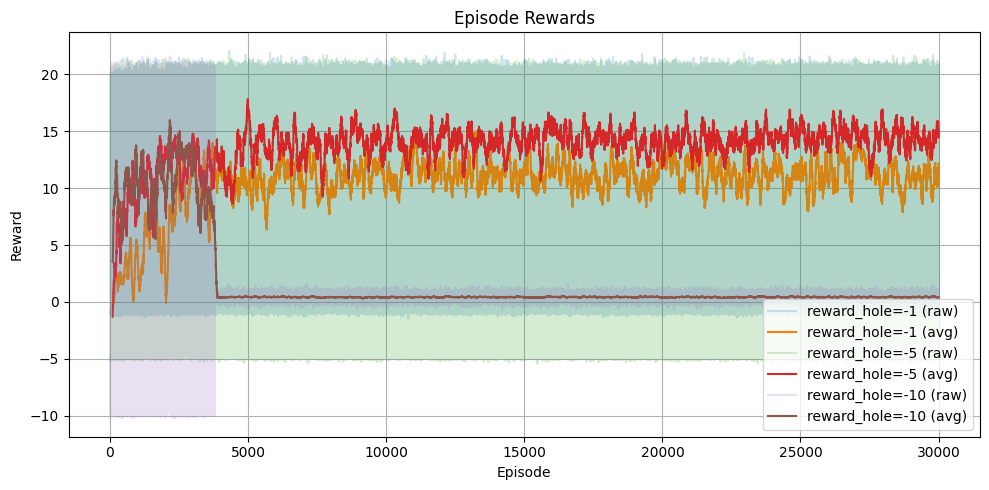

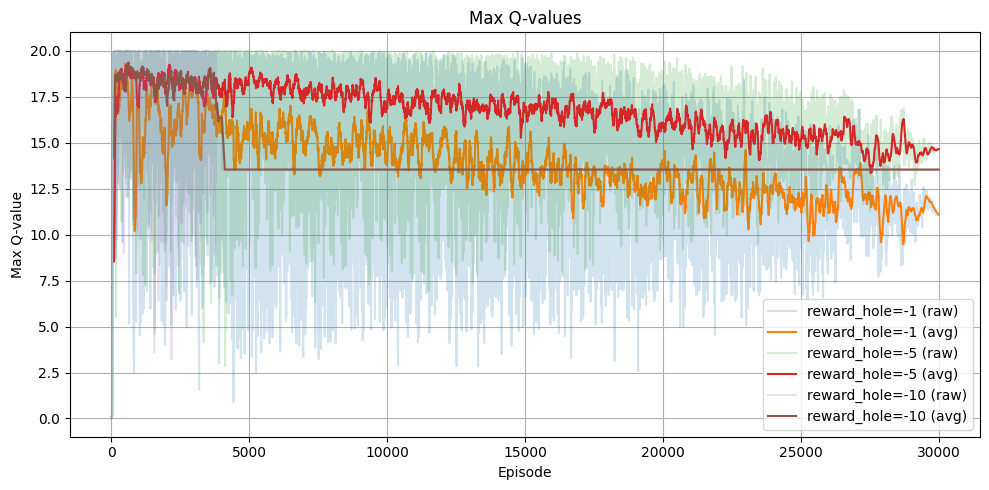

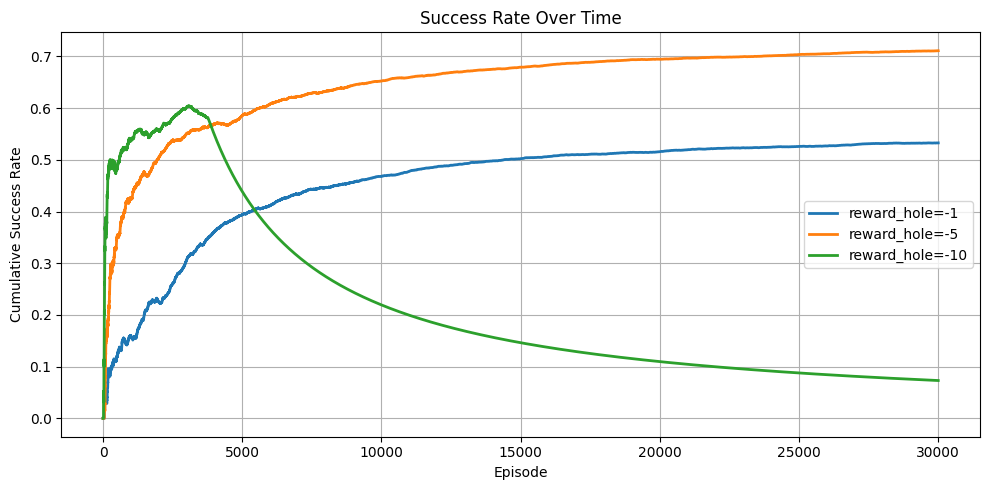

In [41]:
# Plotting the results
def plot_training_metrics(metrics, reward_hole_values, window=100):
    episodes = np.arange(len(metrics[0][0]))  # Assuming all runs have the same number of episodes
    smoothed_range = np.arange(window - 1, len(episodes))

    # --- 1. Reward per Episode ---
    plt.figure(figsize=(10, 5))
    for i, reward_hole in enumerate(reward_hole_values):
        metrics_eps = {"rewards": metrics[i][0], "max_qs": metrics[i][1], "successes": metrics[i][2]}
        plt.plot(episodes, metrics_eps["rewards"], alpha=0.2, label=f"reward_hole={reward_hole} (raw)")
        plt.plot(smoothed_range, moving_average(metrics_eps["rewards"], window), label=f"reward_hole={reward_hole} (avg)")
    plt.title(f"Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # --- 2. Max Q-value per Episode ---
    plt.figure(figsize=(10, 5))
    for i, reward_hole in enumerate(reward_hole_values):
        metrics_eps = {"rewards": metrics[i][0], "max_qs": metrics[i][1], "successes": metrics[i][2]}
        plt.plot(episodes, metrics_eps["max_qs"], alpha=0.2, label=f"reward_hole={reward_hole} (raw)")
        plt.plot(smoothed_range, moving_average(metrics_eps["max_qs"], window), label=f"reward_hole={reward_hole} (avg)")
    plt.title(f"Max Q-values")
    plt.xlabel("Episode")
    plt.ylabel("Max Q-value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # --- 3. Success Rate Over Time ---
    plt.figure(figsize=(10, 5))
    for i, reward_hole in enumerate(reward_hole_values):
        metrics_eps = {"rewards": metrics[i][0], "max_qs": metrics[i][1], "successes": metrics[i][2]}
        success_rate = np.cumsum(metrics_eps["successes"]) / (episodes + 1)
        plt.plot(episodes, success_rate, label=f"reward_hole={reward_hole}", linewidth=2)
    plt.title(f"Success Rate Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Success Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()

plot_training_metrics(list(zip(episode_rewards, max_q_values, successes)), reward_hole_values)

# Experiment 5: Experience Replay

### Config

In [51]:
# Moving average function
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")

# Configuration
class Config:
    def __init__(self):
        self.alpha = 0.8
        self.gamma = 0.95
        self.epsilon = 1.0
        self.min_epsilon = 0.05
        self.epsilon_decay = 0.9999
        self.episodes = 30000
        self.eval_episodes = 1000
        self.slippery = True
        self.reward_goal = 20
        self.reward_hole = -1
        self.reward_step = -0.01


def create_env(slippery=True, seed=42):
    env = gym.make(
        "FrozenLake-v1",
        desc=["SFFF", "FHFH", "FFFH", "HFFG"],
        is_slippery=slippery
    )
    env.reset(seed=seed)
    return env

### Q-learning Algorithm

In [52]:
def boltzmann_exploration(q_values, temp=1.0):
    if temp <= 0:
        return np.argmax(q_values)
    scaled_q = (q_values - np.max(q_values)) / max(temp, 1e-10)
    exp_q = np.exp(scaled_q)
    probabilities = exp_q / np.sum(exp_q)
    if np.isnan(probabilities).any():
        probabilities = np.ones_like(q_values) / len(q_values)
    return np.random.choice(len(q_values), p=probabilities)


def train_boltzmann(config, env, use_replay=False, replay_size=10000, initial_temp=1.0, temp_decay=0.9995, min_temp=0.1):
    np.random.seed(42)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    successes = []
    max_qs = []
    temperature = initial_temp
    replay_buffer = []

    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        transitions = []

        while not done:
            action = boltzmann_exploration(q_table[state], temperature)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reward = config.reward_goal if reward == 1 else config.reward_hole
            else:
                row, col = divmod(state, 4)
                goal_dist = abs(row - 3) + abs(col - 3)
                reward = config.reward_step + 0.01 * (6 - goal_dist)

            transitions.append((state, action, reward, next_state))
            state = next_state
            total_reward += reward

        # Store in replay buffer
        if use_replay:
            replay_buffer.extend(transitions)
            replay_buffer = replay_buffer[-replay_size:]
            batch = transitions + random.sample(replay_buffer, min(len(replay_buffer), 32))
        else:
            batch = transitions

        # Update Q-table
        current_alpha = config.alpha * (1 - episode / config.episodes)
        for state, action, reward, next_state in batch:
            q_table[state, action] += current_alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

        temperature = max(min_temp, temperature * temp_decay)
        episode_rewards.append(total_reward)
        successes.append(1 if reward == config.reward_goal else 0)
        max_qs.append(np.max(q_table))

    return q_table, {
        "rewards": episode_rewards,
        "max_qs": max_qs,
        "successes": successes
    }

In [ ]:
def evaluate(q_table, config):
    eval_env = create_env(config.slippery, seed=1042)
    successes = 0
    for _ in range(config.eval_episodes):
        state, _ = eval_env.reset()
        done = False
        while not done:
            action = np.argmax(q_table[state])
            state, _, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            if terminated and state == 15:
                successes += 1
    return successes / config.eval_episodes


# Run training with and without experience replay
config = Config()

# No experience replay
env = create_env(config.slippery, seed=42)
q_no_replay, metrics_no_replay = train_boltzmann(config, env, use_replay=False)

# With experience replay
env = create_env(config.slippery, seed=42)
q_replay, metrics_replay = train_boltzmann(config, env, use_replay=True)

success_replay = evaluate(q_replay, config)
success_no_replay = evaluate(q_no_replay, config)

print(f"Success rate with experience replay: {success_replay * 100:.2f}%")
print(f"Success rate without experience replay: {success_no_replay * 100:.2f}%")

Success rate with experience replay: 65.30%
Success rate without experience replay: 74.10%


### Creating plots

In [ ]:
def plot_comparison(metrics_no_replay, metrics_replay, window=100):
    episodes = np.arange(len(metrics_no_replay["rewards"]))
    smoothed_range = np.arange(window - 1, len(episodes))

    # --- 1. Episode Rewards ---
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, metrics_no_replay["rewards"], alpha=0.2, label="No Replay (raw)")
    plt.plot(episodes, metrics_replay["rewards"], alpha=0.2, label="With Replay (raw)")
    plt.plot(smoothed_range, moving_average(metrics_no_replay["rewards"], window), label="No Replay (avg)")
    plt.plot(smoothed_range, moving_average(metrics_replay["rewards"], window), label="With Replay (avg)")
    plt.title("Episode Rewards Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 2. Success Rate ---
    success_no_replay = np.cumsum(metrics_no_replay["successes"]) / (episodes + 1)
    success_replay = np.cumsum(metrics_replay["successes"]) / (episodes + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(episodes, success_no_replay, label="No Replay", linewidth=2)
    plt.plot(episodes, success_replay, label="With Replay", linewidth=2)
    plt.title("Cumulative Success Rate Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Success Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_comparison(metrics_no_replay, metrics_replay)

NameError: name 'metrics_without_map' is not defined

# Experiment 6:  Providing Frozen Lake Layout

### Config

In [78]:
# Configuration
class Config:
    def __init__(self):
        self.alpha = 0.8
        self.gamma = 0.95
        self.epsilon = 1.0
        self.min_epsilon = 0.05
        self.epsilon_decay = 0.9999
        self.episodes = 30000
        self.eval_episodes = 1000
        self.slippery = True
        self.reward_goal = 20
        self.reward_hole = -1
        self.reward_step = -0.01

def create_env(slippery=True, seed=42, layout=None):
    if layout is None:
        layout = ["SFFF", "FHFH", "FFFH", "HFFG"]
    elif isinstance(layout[0], list):
        # Convert 2D list to list of strings
        layout = ["".join(row) for row in layout]

    env = gym.make(
        "FrozenLake-v1",
        desc=layout,
        is_slippery=slippery
    )
    env.reset(seed=seed)
    return env

### Q-learning Algorithm

In [79]:
def boltzmann_exploration(q_values, temp=1.0):
    if temp <= 0:
        return np.argmax(q_values)
    scaled_q = (q_values - np.max(q_values)) / max(temp, 1e-10)
    exp_q = np.exp(scaled_q)
    probabilities = exp_q / np.sum(exp_q)
    if np.isnan(probabilities).any():
        probabilities = np.ones_like(q_values) / len(q_values)
    return np.random.choice(len(q_values), p=probabilities)

def train_boltzmann(config, env, initial_temp=1.0, temp_decay=0.9995, min_temp=0.1):
    np.random.seed(42)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    successes = []
    max_qs = []
    temperature = initial_temp

    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = boltzmann_exploration(q_table[state], temperature)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reward = config.reward_goal if reward == 1 else config.reward_hole
            else:
                row, col = divmod(state, 4)
                goal_dist = abs(row - 3) + abs(col - 3)
                reward = config.reward_step + 0.01 * (6 - goal_dist)

            current_alpha = config.alpha * (1 - episode / config.episodes)
            q_table[state, action] += current_alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward

        temperature = max(min_temp, temperature * temp_decay)
        episode_rewards.append(total_reward)
        successes.append(1 if reward == config.reward_goal else 0)
        max_qs.append(np.max(q_table))

    return q_table, {
        "rewards": episode_rewards,
        "max_qs": max_qs,
        "successes": successes
    }

### Evaluation

In [80]:
def evaluate(q_table, config, layout=None):
    eval_env = create_env(config.slippery, seed=1042, layout=layout)
    successes = 0
    for _ in range(config.eval_episodes):
        state, _ = eval_env.reset()
        done = False
        while not done:
            action = np.argmax(q_table[state])
            state, _, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            if terminated and state == 15:
                successes += 1
    return successes / config.eval_episodes

# Define layout for the agent with layout
layout = ["SFFF", "FHFH", "FFFH", "HFFG"]

# Run training for agents with and without layout
config = Config()
metrics_with_map = None
metrics_without_map = None

for layout_flag in [True, False]:
    # Create environments
    if layout_flag:
        env = create_env(slippery=config.slippery, seed=42, layout=layout)
    else:
        env = create_env(slippery=config.slippery, seed=42)

    # Train Boltzmann agent
    q_table, stats = train_boltzmann(config, env)

    # Evaluate using correct layout
    success_rate = evaluate(q_table, config, layout if layout_flag else None)

    # Add success rate to stats for plotting
    stats["successes_eval"] = success_rate
    stats["successes"] = [1 if r > 0 else 0 for r in stats["rewards"]]  # Approximate

    # Store metrics
    if layout_flag:
        metrics_with_map = stats
    else:
        metrics_without_map = stats

    print(f"Success rate for {'with' if layout_flag else 'without'} layout: {success_rate * 100:.2f}%")


Success rate for with layout: 59.90%
Success rate for without layout: 59.90%


### Plotting Heatmap

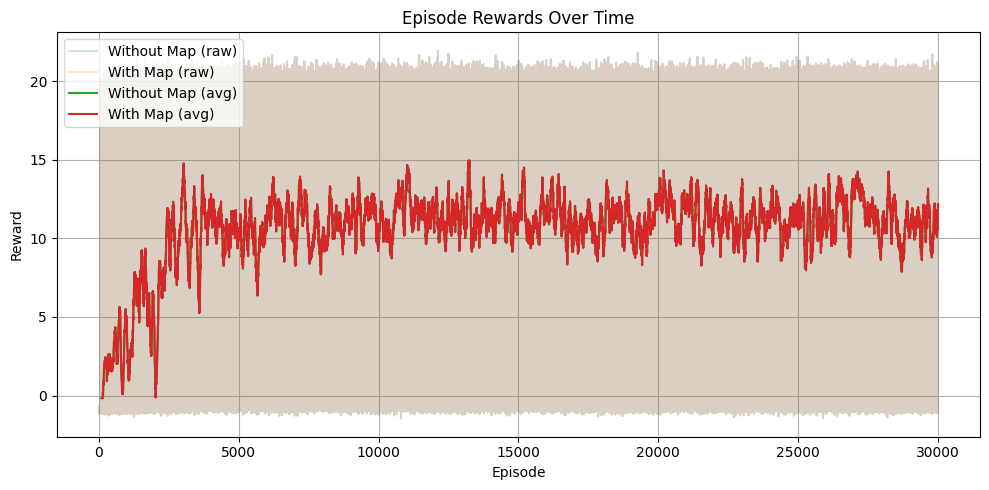

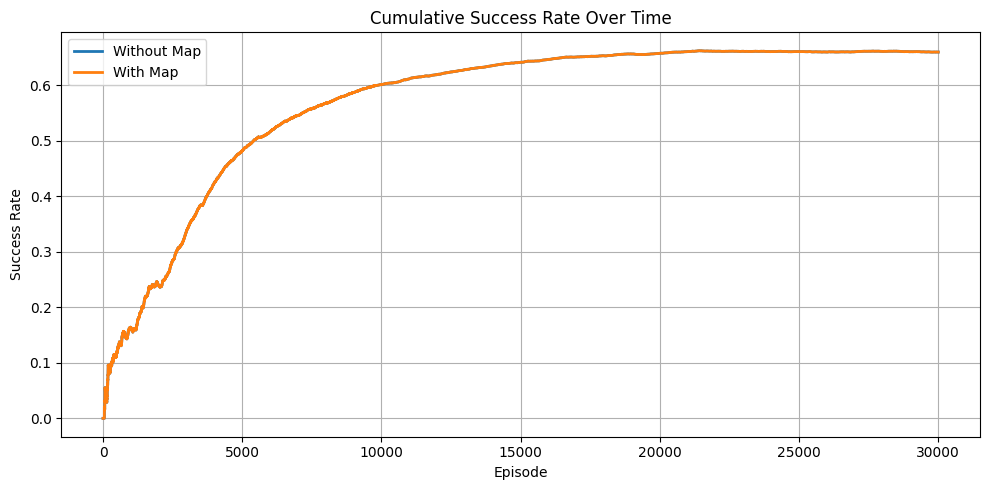

In [75]:
def plot_comparison(metrics_without_map, metrics_with_map, window=100):
    episodes = np.arange(len(metrics_without_map["rewards"]))
    smoothed_range = np.arange(window - 1, len(episodes))

    # --- 1. Episode Rewards ---
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, metrics_without_map["rewards"], alpha=0.2, label="Without Map (raw)")
    plt.plot(episodes, metrics_with_map["rewards"], alpha=0.2, label="With Map (raw)")
    plt.plot(smoothed_range, moving_average(metrics_without_map["rewards"], window), label="Without Map (avg)")
    plt.plot(smoothed_range, moving_average(metrics_with_map["rewards"], window), label="With Map (avg)")
    plt.title("Episode Rewards Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 2. Success Rate ---
    success_without_map = np.cumsum(metrics_without_map["successes"]) / (episodes + 1)
    success_with_map = np.cumsum(metrics_with_map["successes"]) / (episodes + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(episodes, success_without_map, label="Without Map", linewidth=2)
    plt.plot(episodes, success_with_map, label="With Map", linewidth=2)
    plt.title("Cumulative Success Rate Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Success Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_comparison(metrics_without_map, metrics_with_map)